In [50]:
#Import bibs
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
%matplotlib notebook
import itertools
import os
import sys
from IPython.display import display, HTML

In [51]:
#Import funtions
sys.path.insert(0, '../Implementation_Events_Kopie/')
from Event_detection_functions import *
sys.path.insert(0, '../')
from IMPORT_DATAFRAME_JSON_HDF5 import *
from plot_transients_function import *

In [69]:
#Set up the date to plot
day = '09'
month = '08'
year = '2017'
date_HDF5 = year+'-'+month+'-'+day
HDF5_filepath = '../../../HDF5/'+date_HDF5+'/'

In [76]:
#Import transients of the day
transients_path = '../../../transients_new/'+month+'/'
#transients_clean
#transients = import_trasient_from_file(transients_path)
#transients prepared
transients = pd.read_pickle('G:/Dropbox/Dropbox/Uni/Master/Master 6/PUEL/04_Data/Transients_with_charging_plugin_info_05_02_to_23_09/df_transients_charging_plugin_'+month)

In [77]:
transients['begin_timestamp_string'] = transients['begin_timestamp_string'].apply(convert_to_datetime)
transients = transients[transients['begin_timestamp_string'].dt.day == int(day)]
transients['minute_index'] = transients['begin_timestamp_string'].dt.hour*60+transients['begin_timestamp_string'].dt.minute

In [72]:
#transients = transients[transients['plugin_on_this_phase']==True]

In [73]:
#Import corresponding HDF5 files for the date and convert them to minute values
Phase_1,P_Phase_1,no_load_p_1=[],[],[]
Phase_2,P_Phase_2,no_load_p_2=[],[],[]
Phase_3,P_Phase_3,no_load_p_3=[],[],[]
Phase_dictionary = {1:Phase_1, 2:Phase_2,3:Phase_3}
no_load_p_dict = {1:no_load_p_1, 2:no_load_p_2,3:no_load_p_3}
for Phase in [1,2,3]:
    Phase_dictionary[Phase]=pd.read_hdf('../../../HDF5/'+date_HDF5+'/phase_'+str(Phase)+'_' + date_HDF5+'.h5',columns =['P', 'timestamps'])
    Phase_dictionary[Phase]=Phase_dictionary[Phase].groupby(np.arange(len(Phase_dictionary[Phase]))//300).mean()
    Phase_dictionary[Phase]['P_delta']=Phase_dictionary[Phase]['P'].diff()
    no_load_p_dict[Phase]=Phase_dictionary[Phase].iloc[0]['P']

In [74]:
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                       'Ladevorgang', 'Status', 'Ladeleistung',
                                       'minuten_index_Abschaltung','timestamp_abschalt'])

#check if event_df already exists
if (os.path.exists(HDF5_filepath+date_HDF5+'_event_df.pkl') == False):

#Simulate event detection code
    backtrack_timesteps=7
    with progressbar.ProgressBar(max_value=len(Phase_dictionary[1])) as bar:
        for minute_day in range(2,max(len(Phase_dictionary[1]),len(Phase_dictionary[2]),len(Phase_dictionary[3]))):
            bar.update(minute_day)
            # Insert this in the update routine after the power_today_minute.csv export
            # The following variables have to be set to the corresponding dataframe in the environment (export to power_today_minute_x.csv)
            phase_dict = {1:P_Phase_1, 2:P_Phase_2, 3:P_Phase_3}
            for Phase in [1,2,3]:
                phase_dict[Phase]=Phase_dictionary[Phase][max(0,minute_day-backtrack_timesteps):minute_day]
                Event_df = detect_switch_event(phase_dict[Phase], Phase, Event_df, no_load_p_dict[Phase])
    Event_df.to_pickle(HDF5_filepath+date_HDF5+'_event_df.pkl')
else:
    Event_df = pd.read_pickle(HDF5_filepath+date_HDF5+'_event_df.pkl')

<IPython.core.display.Javascript object>


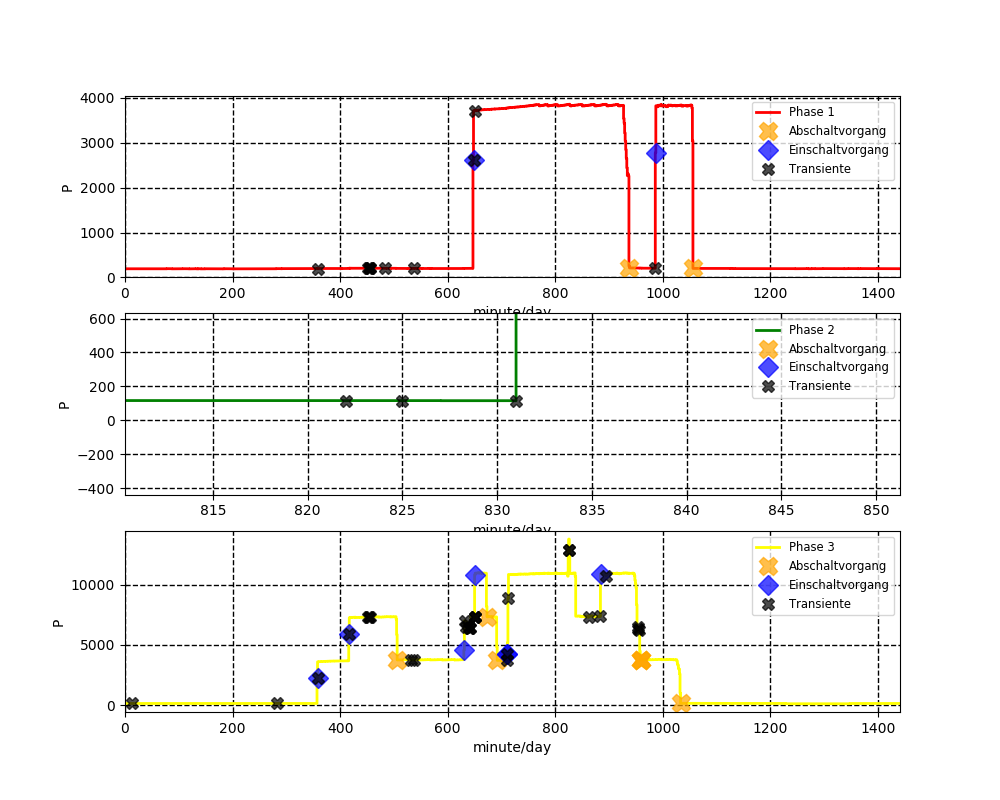

In [75]:
colors_phase = ['red','green','yellow']
plt.figure(figsize=(10,8))
for Phase in [1,2,3]:
    Phase_P = Phase_dictionary[Phase]
    plt.subplot(310+Phase)
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']+1]['P'], "X",color="orange", markersize=13,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=10,alpha=.7, label='Einschaltvorgang')
    plt.plot(transients[transients.phase_num == Phase]['minute_index'],Phase_P.iloc[transients[transients.phase_num==Phase]['minute_index']]['P'],"X", color="black", markersize=8,alpha=.7, label='Transiente')
    plt.legend(loc='upper right', frameon=True, fontsize = 'small')
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,len(Phase_P)])
    plt.ylabel('P')
    plt.xlabel('minute/day')

<IPython.core.display.Javascript object>


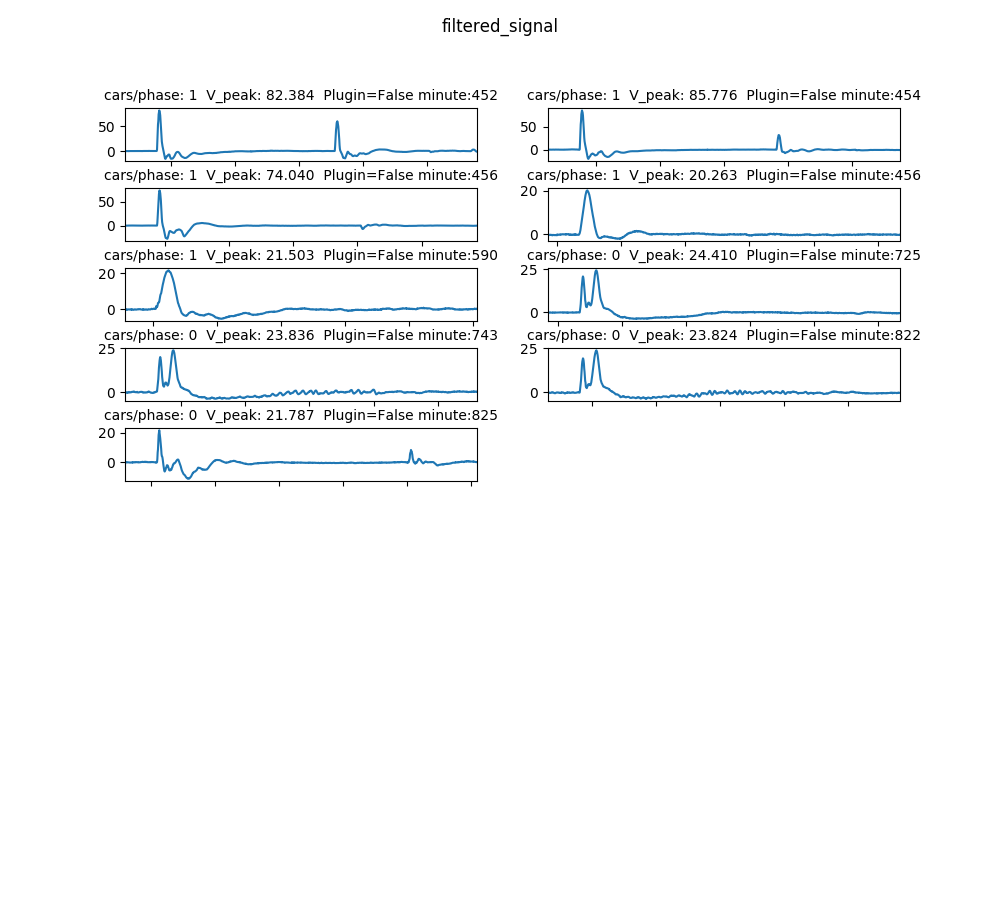

In [83]:
transients_1 = transients[(transients['phase_num']==2) & (transients['plugin']==False)]
plot_transients(transients_1,len(transients_1)-1,'filtered_signal',2)

In [84]:
transients_1

,begin_timestamp_float_x,begin_index,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient,...,three_phases,cars_phase_1,cars_phase_2,cars_phase_3,plugin,plugin_phase_1,plugin_phase_2,plugin_phase_3,plugin_on_this_phase,minute_index
230,1.502230e+09,731,2017-08-09 00:09:02.831845,"[-0.10765988380000001, -0.0960686058, -0.15950...",2,"[0.5798339844, 0.6103515625, 0.5798339844, 0.5...","[301.7278137207, 301.8316040039, 301.987335205...","[23.913, 4.103, 2.737]","[783, 901, 1026]",2.286939e+05,...,0.0,0.0,0.0,0.0,False,False,False,False,NaN,9
239,1.502257e+09,757,2017-08-09 07:32:25.957446,"[0.103787445, 0.22057819920000002, 0.259518608...",2,"[20.4467773438, 20.4162597656, 20.4772949219, ...","[291.0357055664, 291.0486755371, 291.126525878...","[82.384, 15.999, 60.325]","[764, 783, 1320]",5.691770e+06,...,0.0,0.0,1.0,2.0,False,False,False,False,NaN,452
242,1.502257e+09,549,2017-08-09 07:34:20.942708,"[0.2400532091, 0.3569965765, 0.356763431800000...",2,"[20.2178955078, 20.2941894531, 20.2789306641, ...","[291.1394958496, 291.1654663086, 291.243316650...","[85.776, 20.004, 32.002]","[556, 576, 1170]",6.039168e+06,...,0.0,0.0,1.0,2.0,False,False,False,False,NaN,454
245,1.502257e+09,1574,2017-08-09 07:36:02.962959,"[0.0648960069, -0.0129543451, 0.1038364173, 0....",2,"[19.7906494141, 19.775390625, 19.7906494141, 1...","[290.7242736816, 290.8540344238, 290.918914794...","[74.040, 27.794, 22.565]","[1582, 1606, 1659]",4.623464e+06,...,0.0,0.0,1.0,2.0,False,False,False,False,NaN,456
247,1.502257e+09,1470,2017-08-09 07:36:03.022771,"[-0.0431766361, 0.0750001222, -0.0301783402, -...",2,"[23.4985351562, 23.5137939453, 23.5595703125, ...","[290.9448547363, 290.9059448242, 291.113555908...","[20.263, 2.160, 1.619]","[1494, 1588, 4603]",-4.112705e+05,...,0.0,0.0,1.0,2.0,False,False,False,False,NaN,456
254,1.502265e+09,1812,2017-08-09 09:50:00.406866,"[-0.1105344852, 0.0970697917, -0.05850445, 0.0...",2,"[-19.6533203125, -19.6228027344, -19.638061523...","[-290.4258422852, -290.5815429688, -290.620483...","[21.503, 5.401, 1.527]","[1848, 2013, 2180]",-2.834582e+05,...,0.0,0.0,1.0,1.0,False,False,False,False,NaN,590
273,1.502273e+09,668,2017-08-09 12:05:30.620414,"[0.1606121831, 0.1749496488, 0.2124022228, 0.3...",2,"[0.6713867188, 0.6561279297, 0.5798339844, 0.6...","[296.303894043, 296.3817443848, 296.4985351562...","[24.410, 3.692, 2.889]","[719, 836, 956]",2.386153e+05,...,0.0,1.0,0.0,3.0,False,False,False,False,NaN,725
274,1.502274e+09,5724,2017-08-09 12:23:22.786411,"[0.17264315230000002, 0.2113108193, 0.21162388...",2,"[-1.2359619141, -1.2359619141, -1.2512207031, ...","[-298.0167236328, -298.0426635742, -298.185394...","[23.836, 3.716, 3.305]","[5775, 5881, 5995]",2.287812e+05,...,0.0,1.0,0.0,3.0,False,False,False,False,NaN,743
275,1.502279e+09,763,2017-08-09 13:42:02.640181,"[-0.19464791680000001, -0.16870798080000002, -...",2,"[0.5493164062, 0.5798339844, 0.5187988281, 0.5...","[295.3696289062, 295.4604797363, 295.551300048...","[23.824, 3.607, 2.375]","[815, 969, 1136]",2.291985e+05,...,0.0,1.0,0.0,1.0,False,False,False,False,NaN,822
276,1.502279e+09,4620,2017-08-09 13:45:03.044171,"[0.0034564766, 0.0168204289, -0.009481458, 0.0...",2,"[0.5798339844, 0.5645751953, 0.5645751953, 0.5...","[295.8497314453, 295.9276123047, 296.044372558...","[21.787, 11.058, 8.427]","[4627, 4716, 5413]",1.543700e+06,...,0.0,1.0,0.0,1.0,False,False,False,False,NaN,825
